In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# Position of detection stations
R = np.zeros((6,3))
R[0] = np.array([2.0 ,20.0 ,0.0])
R[1] = np.array([-2.0,-1.0 ,0.0])
R[2] = np.array([5.0 ,12.0 ,0.0])
R[3] = np.array([8.0 ,10.0 ,0.0])
R[4] = np.array([5.0 ,-16.0,0.0])
R[5] = np.array([1.0 ,40.0 ,0.0])
# Times of arrival
T = np.array([3.23,3.82,2.27,3.04,5.65,6.57])
print(R,T)

[[  2.  20.   0.]
 [ -2.  -1.   0.]
 [  5.  12.   0.]
 [  8.  10.   0.]
 [  5. -16.   0.]
 [  1.  40.   0.]] [ 3.23  3.82  2.27  3.04  5.65  6.57]


In [70]:
# Uncertainty in time, declared velocity
sigmat = 0.05
v      = 5.0

(-10, 40)

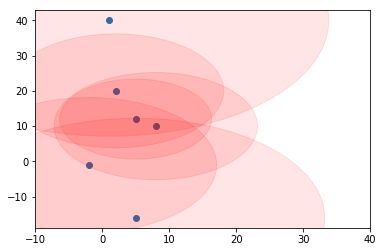

In [80]:
fig, ax = plt.subplots()
ax.scatter(R.T[0],R.T[1])
for i in range(6):
    circle1 = plt.Circle((R[i][0],R[i][1]), v*T[i], color='r',alpha= 0.1)
    ax.add_artist(circle1)
#plt.Circle((R-10-[0],R.T[1]), v*T[i], color='r')
ax.set_xlim(-10,40)


Let us take the most simple model for the propagation of the sismic wave:

$\left|\vec{r}-\vec{r}_0\right| = vt$

Where $\vec{r}$ is the position in which the wave is detected, $\vec{r}_0$ is the epicenter and $t$ is the time of arrival.

This leads us to the theoretical model for the time:
$t = \left|\vec{r}-\vec{r}_0\right|/v$

Which defines the $\chi^2$:

$$\chi^2= \frac{1}{2}\sum \frac{(t_{obs} -t_{theo})^2}{\sigma_t} = \sum \frac{\left(t_{obs} -\frac{\left|\vec{r_{obs}}-\vec{r}_0\right|}{v}\right)^2}{\sigma_t}$$

With this, Hamiltonian is defined with potential related to -log(likelihood)


In [66]:
# Structure of code from: 
#https://github.com/ComputoCienciasUniandes/MetodosComputacionalesAvanzados/blob/master/weeks/09/hamiltoniano.ipynb 
# x,y,z is r0
def likelihood(epiR):
    x,y,z = epiR
    like = np.exp(-0.5*np.sum( (T - (1.0/v)*((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2))**2))
def loglikelihood(epiR):
    x,y,z = epiR
    return -0.5*np.sum( (T - (1.0/v)*((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2))**2)
# vector
def gradient_loglikelihood(epiR):
    x,y,z = epiR
    #print(x,y,z)
    return np.array([np.sum(-(2.0/v)*(T - (1.0/v)*((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2))
            *(1.0/((x-R.T[0])**2+(y-R.T[1])**2+(z-R.T[2])**2))*(R.T[i]-epiR[i])) for i in range(3)])
# epiR, epiP are vectors
def leapfrog(epiR,epiP, delta_t=0.5E-2, niter=10):
    epiR_new = epiR.copy()
    epiP_new = epiP.copy()
    for i in range(niter):
        epiP_new = epiP_new + 0.5 * delta_t * gradient_loglikelihood(epiR_new)
        epiR_new = epiR_new + delta_t * epiP_new
        epiP_new = epiP_new + 0.5 * delta_t * gradient_loglikelihood(epiR_new)
    return epiR_new, epiP_new

def H(epiR,epiP):
    K = 0.5 * np.linalg.norm(epiP)**2
    U = -loglikelihood(epiR)
    return K + U

## HAMILTONIAN MCMC IS NOW PREPARED ##

In [67]:
def MCMC(nsteps):
    epiR = np.zeros((nsteps,3))
    epiP = np.zeros((nsteps,3))
    # Defines sigmap and sigmar
    sigmar = 1
    sigmap = 1
    epiP[0] = np.array([np.random.normal(0,sigmap),np.random.normal(0,sigmap),np.random.normal(0,sigmap)])
    epiR[0] = np.array([np.random.normal(0,sigmar),np.random.normal(0,sigmar),np.random.normal(0,sigmar)])
    for i in range(1,nsteps):
        epiP[i] = np.array([np.random.normal(0,sigmap),np.random.normal(0,sigmap),np.random.normal(0,sigmap)])
        epiR_new, epiP_new = leapfrog(epiR[i-1],epiP[i-1])
        E_new = H(epiR_new, epiP_new)
        E_old = H(epiR[i-1], epiP[i-1])
        alpha = min(1.0,np.exp(-E_new + E_old))
        beta = np.random.random()
        if beta < alpha:
            epiR[i] = epiR_new
        else:
            epiR[i] = epiR[i-1]
    return epiR

In [68]:
epiR_chain = MCMC(1000)


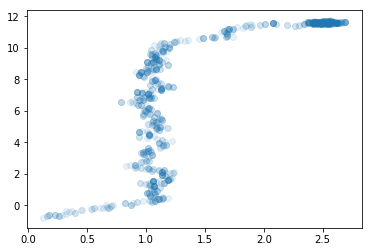

In [69]:
scatter(epiR_chain.T[0],epiR_chain.T[1],alpha=0.1)

In [37]:
len(epiR_chain.T[1])

10000

In [ ]:
fig, ax = plt.subplots()
ax.scatter(R.T[0],R.T[1])
for i in range(6):
    circle1 = plt.Circle((R[i][0],R[i][1]), v*T[i], color='r',alpha= 0.1)
    ax.add_artist(circle1)
#plt.Circle((R-10-[0],R.T[1]), v*T[i], color='r')
ax.set_xlim(-10,40)
